# Near-Field Validation

This notebook validates `miepython` near-field electric and magnetic fields against
precomputed references from **scattnlay**:

- Project: [scattnlay](https://github.com/ovidiopr/scattnlay)
- Implementation: C++ (with Python bindings / CLI)
- Scope: electromagnetic scattering and near fields for multilayered spheres

Reference arrays are generated by:

`python docs/data/generate_scattnlay_reference_fields.py`

and stored in `docs/data/` as `.npy` files.


## Convention Alignment (scattnlay vs miepython)

To compare fields correctly, we align these conventions:

1. Coordinate units
- `scattnlay fieldnlay` uses dimensionless positions `k*r`.
- Stored reference grids in this repository are converted back to physical coordinates.

2. Absorption sign convention
- `miepython` uses `m = n - i k`.
- For this validation setup, absorbing scattnlay input is provided as positive imaginary part.
  The physical miepython case `1.5 - 0.1j` is compared to scattnlay reference data generated with `1.5 + 0.1j`.

3. Magnetic-field normalization
- scattnlay returns `H` in physical `E/H` units.
- `miepython.field.eh_near_cartesian` returns `H` normalized to incident `E`.
- We scale scattnlay `|H|` by medium impedance: `eta_env = eta0 / n_env`, `eta0 = 376.730313667`.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from miepython.field import eh_near_cartesian


def find_data_dir(default=Path("data")):
    candidates = [default, Path("docs") / default]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        "Could not find reference data directory. "
        "Run: python docs/generate_scattnlay_reference_fields.py"
    )


def load_scattnlay_case_from_npy(case_key, data_dir=None):
    base = find_data_dir() if data_dir is None else Path(data_dir).resolve()
    paths = {
        "X": base / f"scattnlay_{case_key}_X.npy",
        "Z": base / f"scattnlay_{case_key}_Z.npy",
        "E": base / f"scattnlay_{case_key}_E.npy",
        "H": base / f"scattnlay_{case_key}_H.npy",
    }

    missing = [str(path) for path in paths.values() if not path.exists()]
    if missing:
        msg = "Missing precomputed scattnlay files:\n" + "\n".join(missing)
        msg += "\nRun: python docs/generate_scattnlay_reference_fields.py"
        raise FileNotFoundError(msg)

    X = np.load(paths["X"])
    Z = np.load(paths["Z"])
    E = np.load(paths["E"])
    H = np.load(paths["H"])
    return X, Z, E, H


def summarize_errors(label, Eabs_s, Eabs_m, Habs_s, Habs_m):
    E_rel_err = np.abs(Eabs_m - Eabs_s) / np.maximum(Eabs_s, 1e-12)
    H_rel_err = np.abs(Habs_m - Habs_s) / np.maximum(Habs_s, 1e-12)

    print(f"[{label}] scattnlay max |E| = {np.max(Eabs_s):.6g}")
    print(f"[{label}] miepython max |E| = {np.max(Eabs_m):.6g}")
    print(f"[{label}] scattnlay max |H| (eta-scaled) = {np.max(Habs_s):.6g}")
    print(f"[{label}] miepython max |H| = {np.max(Habs_m):.6g}")
    print(f"[{label}] E relative error median/max = {np.median(E_rel_err):.3e} / {np.max(E_rel_err):.3e}")
    print(f"[{label}] H relative error median/max = {np.median(H_rel_err):.3e} / {np.max(H_rel_err):.3e}")

    return E_rel_err, H_rel_err


def plot_comparison(title, Xg, Zg, radius, Eabs_s, Eabs_m, E_rel_err, Habs_s, Habs_m, H_rel_err):
    fig, axes = plt.subplots(2, 3, figsize=(13, 8), constrained_layout=True)

    plots = [
        (Eabs_s, "scattnlay |E|", "turbo"),
        (Eabs_m, "miepython |E|", "turbo"),
        (E_rel_err, "|E| relative error", "viridis"),
        (Habs_s, "scattnlay |H| (eta-scaled)", "magma"),
        (Habs_m, "miepython |H|", "magma"),
        (H_rel_err, "|H| relative error", "viridis"),
    ]

    for ax, (arr, ttl, cmap) in zip(axes.flat, plots):
        im = ax.imshow(
            arr.T,
            origin="lower",
            extent=(Xg.min(), Xg.max(), Zg.min(), Zg.max()),
            cmap=cmap,
            aspect="equal",
        )
        circle_color = "w" if cmap in ("magma", "viridis") else "k"
        ax.add_patch(plt.Circle((0.0, 0.0), radius, fill=False, color=circle_color, lw=1.1))
        ax.set_title(ttl)
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    fig.suptitle(title, y=1.02)


## Non-Absorbing Sphere Test

Parameters:
- `m = 1.5 + 0.0j`
- `d = 2`
- `n_env = 1`
- `lambda0 = 1`


[Non-absorbing] scattnlay max |E| = 5.00558
[Non-absorbing] miepython max |E| = 5.00558
[Non-absorbing] scattnlay max |H| (eta-scaled) = 7.25048
[Non-absorbing] miepython max |H| = 7.25036
[Non-absorbing] E relative error median/max = 1.063e-11 / 9.649e-01
[Non-absorbing] H relative error median/max = 5.494e-10 / 3.820e-05


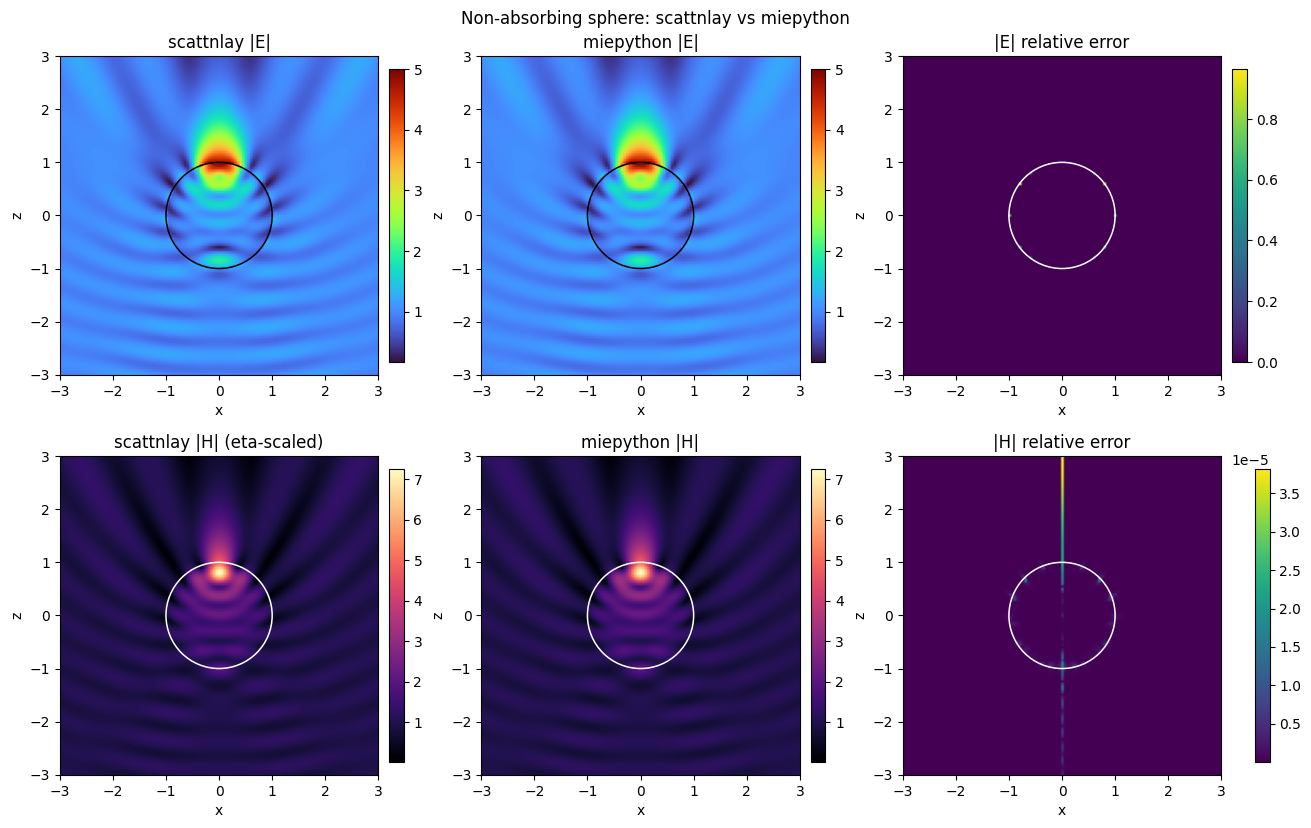

In [2]:
# Shared constants
n_env = 1.0
d_sphere = 2.0
radius = d_sphere / 2.0
lambda0 = 1.0
eta0 = 376.730313667
eta_env = eta0 / n_env

# scattnlay reference from .npy
Xg, Zg, E_s, H_s = load_scattnlay_case_from_npy("nonabs")

# miepython evaluation on the exact same grid
E_m, H_m = eh_near_cartesian(
    lambda0,
    d_sphere,
    1.5 + 0.0j,
    n_env,
    Xg,
    np.zeros_like(Xg),
    Zg,
    include_incident=True,
)

Eabs_s = np.sqrt(np.sum(np.abs(E_s) ** 2, axis=0))
Habs_s_raw = np.sqrt(np.sum(np.abs(H_s) ** 2, axis=0))
Habs_s = eta_env * Habs_s_raw

Eabs_m = np.sqrt(np.sum(np.abs(E_m) ** 2, axis=0))
Habs_m = np.sqrt(np.sum(np.abs(H_m) ** 2, axis=0))

E_rel_err, H_rel_err = summarize_errors("Non-absorbing", Eabs_s, Eabs_m, Habs_s, Habs_m)
plot_comparison(
    "Non-absorbing sphere: scattnlay vs miepython",
    Xg,
    Zg,
    radius,
    Eabs_s,
    Eabs_m,
    E_rel_err,
    Habs_s,
    Habs_m,
    H_rel_err,
)


## Absorbing Sphere Test

Physical parameters:
- miepython sphere index: `1.5 - 0.1j`
- `d = 2`
- `n_env = 1`
- `lambda0 = 1`

Sign mapping used in this notebook:
- scattnlay reference arrays loaded from case `abs` were generated with `1.5 + 0.1j`
- miepython is evaluated using the physical convention `1.5 - 0.1j`


[Absorbing] scattnlay max |E| = 2.32745
[Absorbing] miepython max |E| = 2.32745
[Absorbing] scattnlay max |H| (eta-scaled) = 3.13324
[Absorbing] miepython max |H| = 3.13317
[Absorbing] E relative error median/max = 1.199e-11 / 8.628e-01
[Absorbing] H relative error median/max = 5.497e-10 / 9.166e-04


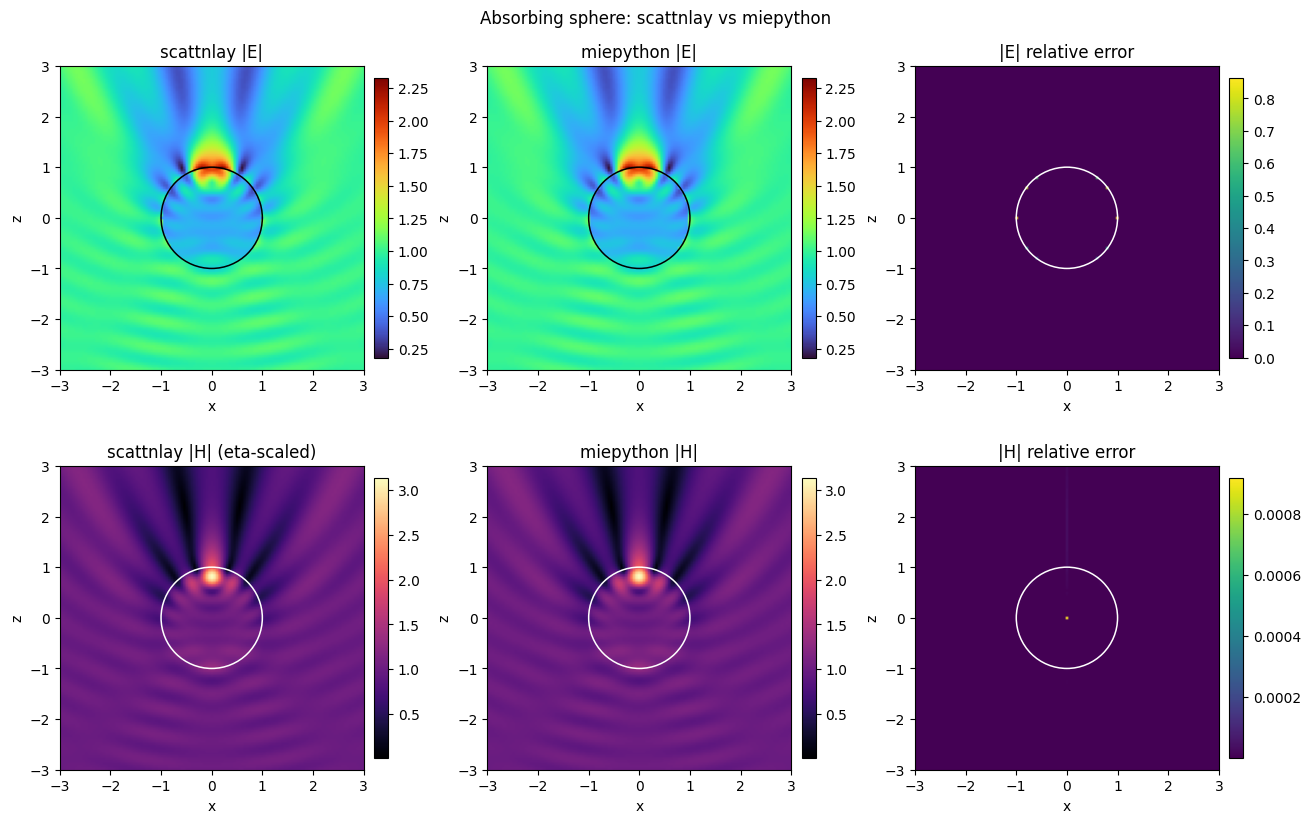

In [3]:
# scattnlay reference from .npy (generated with scattnlay input m=1.5+0.1j)
Xg2, Zg2, E_s2, H_s2 = load_scattnlay_case_from_npy("abs")

# miepython physical absorbing convention m = 1.5 - 0.1j
E_m2, H_m2 = eh_near_cartesian(
    lambda0,
    d_sphere,
    1.5 - 0.1j,
    n_env,
    Xg2,
    np.zeros_like(Xg2),
    Zg2,
    include_incident=True,
)

Eabs_s2 = np.sqrt(np.sum(np.abs(E_s2) ** 2, axis=0))
Habs_s2_raw = np.sqrt(np.sum(np.abs(H_s2) ** 2, axis=0))
Habs_s2 = eta_env * Habs_s2_raw

Eabs_m2 = np.sqrt(np.sum(np.abs(E_m2) ** 2, axis=0))
Habs_m2 = np.sqrt(np.sum(np.abs(H_m2) ** 2, axis=0))

E_rel_err2, H_rel_err2 = summarize_errors("Absorbing", Eabs_s2, Eabs_m2, Habs_s2, Habs_m2)
plot_comparison(
    "Absorbing sphere: scattnlay vs miepython",
    Xg2,
    Zg2,
    radius,
    Eabs_s2,
    Eabs_m2,
    E_rel_err2,
    Habs_s2,
    Habs_m2,
    H_rel_err2,
)
